### _Can someone please volunteer to try to apply the example below to the auth.txt.gz dataset.  If we can load the data into this format and usefully manipulate it, we should be able to do analysis on the entire dataset, rather than just the dns log._

### Are you able plot the computers with the top 50 incoming requests from the 'auth.txt.gz dataset?

***

___

---

# Tutorial on using PyTables for Larger-than-RAM Data Processing by Kyle Kastner - 20 July 2015 

Extract only - see full Source [here](https://kastnerkyle.github.io/posts/using-pytables-for-larger-than-ram-data-processing/)

__## AH comment ## Some of the code in the linked tutorial has been amended here to match the syntax for the current version.  I have also included extra explanation and checks of data types where it wasn't clear to me what was going on.__

HDF5 is a direct, easy path to "big" (or just annoyingly larger than RAM) data in scientific python. Using the HDF5 file format and careful coding of your algorithms, it is quite possible to process "big-ish" data on modest hardware, and really push your resources to the limit before moving to larger, fancier distributed platforms.

There are two primary options for working with HDF5 files in python: H5Py and PyTables. While many people enjoy H5Py, I am much more familiar with PyTables and prefer it for most tasks. This blog will show a variety of PyTables examples for several potential applications including standard numpy nd-array replacement, variable length (ragged) arrays, iterator rewriting for simpler retrieval of data, and on-the-fly compression/decompression. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

To test our various techniques for storing data in HDF5, first we need some data to store. Here I have created a quick function which will generate random data from four clusters, as well as returning the cluster label for each datapoint. This data generator should be sufficient for testing all the PyTables techniques I will show in this post.

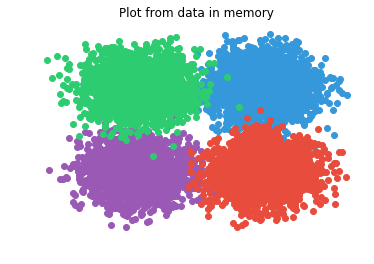

In [2]:
random_state = np.random.RandomState(1999)

def make_random_cluster_points(n_samples, random_state=random_state):
    mu_options = np.array([(-1, -1), (1, 1), (1, -1), (-1, 1)])
    sigma = 0.4
    mu_choices = random_state.randint(0, len(mu_options), size=n_samples)
    means = mu_options[mu_choices]
    return means + np.random.randn(n_samples, 2) * sigma, mu_choices

def plot_clusters(data, clusters, name):
    plt.figure()
    colors = ["#9b59b6", "#3498db", "#e74c3c", "#2ecc71"]
    for i in np.unique(clusters):
        plt.scatter(data[clusters==i, 0], data[clusters==i, 1], color=colors[i])
    plt.axis('off')
    plt.title('Plot from %s' % name)

data, clusters = make_random_cluster_points(10000)
plot_clusters(data, clusters, "data in memory")

First, a brief high level discussion of how HDF5 and PyTables work. I think the website says it best:

___
_PyTables is a package for managing hierarchical datasets and designed to efficiently and easily cope with extremely large amounts of data. You can download PyTables and use it for free [...] One important feature of PyTables is that it optimizes memory and disk resources so that data takes much less space (specially if on-flight compression is used) than other solutions such as relational or object oriented databases."_
___

PyTables allows us to quickly and easily deal with large volumes of on-disk data, while largely keeping the complexity of the data storage invisible to the downstream processing in numpy, scipy, theano, etc. Depending on the algorithms used downstream, you can sometimes drop in hdf5 data to replace a numpy array and everything will keep working exactly like before - when this happens it is quite an amazing feeling.

First we will start with the simplest use for HDF5 - data persistence. We will show this using two types of Arrays provided by PyTables - Array and CArray.

We take the following steps below:

1. Importing PyTables with `import tables`
2. Creating some data
3. Creating a new hdf5 file (or overwriting the old one at the same place!)
4. Adding a PyTables `Array` to hold the data, and storing data in it.

In [3]:
import tables

sample_data, sample_clusters = make_random_cluster_points(10000)
hdf5_path = "my_data.hdf5"
hdf5_file = tables.open_file(hdf5_path, mode='w')
data_storage = hdf5_file.create_array(hdf5_file.root, 'data', sample_data)
clusters_storage = hdf5_file.create_array(hdf5_file.root, 'clusters', sample_clusters)
hdf5_file.close()

In [4]:
sample_data[0:5,]

array([[ 0.82427747, -1.05147241],
       [-0.8377168 , -0.37776396],
       [-0.38367775,  1.30179777],
       [ 1.40211038,  0.89182731],
       [-0.73537101, -0.62676445]])

In [5]:
sample_clusters[0:5,]

array([2, 0, 1, 1, 0])

Now we can open the file, and use the data in it for the same things that we used the old arrays for. Make sure to notice that we are slicing (using [:]) the `data` and `clusters` back into memory so that we can use these variables for plotting. More on this in a moment.

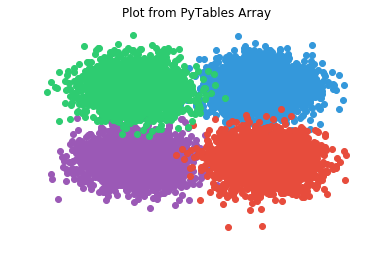

In [6]:
hdf5_path = "my_data.hdf5"
read_hdf5_file = tables.open_file(hdf5_path, mode='r')
# Here we slice [:] all the data back into memory, then operate on it
hdf5_data = read_hdf5_file.root.data[:]
hdf5_clusters = read_hdf5_file.root.clusters[:]
read_hdf5_file.close()

plot_clusters(hdf5_data, hdf5_clusters, "PyTables Array")

In [7]:
hdf5_data[0:5,]

array([[ 0.82427747, -1.05147241],
       [-0.8377168 , -0.37776396],
       [-0.38367775,  1.30179777],
       [ 1.40211038,  0.89182731],
       [-0.73537101, -0.62676445]])

So why did we need to slice the data in order to use it? This comes from the way that PyTables manages on-disk versus in memory data.

A PyTables array lives on disk until some data is sliced out using standard numpy notation. At that point, the data slice is read into memory from the disk, for the lifetime of that slice. Once the slice is finished being used, the python garbage collector will try to free the memory of the slice and any changes (if you made them) can be written back to the PyTables array on disk.

This makes PyTables a nearly transparent drop in for numpy arrays which are larger than memory but only need to be processed a little bit at a time. For my own usage, I typically have some separate scripts to preprocess and write data to an hdf5 file, and all algorithmic processing scripts open this as read only - this is very similar to what we have seen above.

## Compression using CArray
Now that we have seen a basic array, we can take a look at using a compressed array, the CArray. PyTables makes it really easy to store and read compressed data from disk.

In [8]:
sample_data, sample_clusters = make_random_cluster_points(10000)
hdf5_path = "my_compressed_data.hdf5"
hdf5_file = tables.open_file(hdf5_path, mode='w')
filters = tables.Filters(complevel=5, complib='blosc')
data_storage = hdf5_file.create_carray(hdf5_file.root, 'data',
                                      tables.Atom.from_dtype(sample_data.dtype),
                                      shape=sample_data.shape,
                                      filters=filters)
clusters_storage = hdf5_file.create_carray(hdf5_file.root, 'clusters',
                                          tables.Atom.from_dtype(sample_clusters.dtype),
                                          shape=sample_clusters.shape,
                                          filters=filters)
data_storage[:] = sample_data
clusters_storage[:] = sample_clusters
hdf5_file.close()

Here we have introduced a few more key PyTables constructs: [compression filters](http://www.pytables.org/usersguide/libref/helper_classes.html#tables.Filters) and [Atom](http://www.pytables.org/usersguide/libref/declarative_classes.html#atomclassdescr) types.

Compression filters are incredibly easy to use, and can provide a massive benefit to through put and disk usage. Usage is as simple as what I showed above - simply define a filter and then use it when creating any of the compressible arrays (CArray, EArray (to be introduced)).

___
`filters = tables.Filters(complevel=5, complib='blosc')`
___

The `complevel` parameter refers to the level of compression, while the `complib` parameter is the compression method.

Arguments for complib are `blosc`, `zlib`, and `lzo` , with `blosc` being my goto compressor. There is a very in depth discussion of different compression algorithms here. If you are really tuning PyTables and HDF5 for your application, I highly advise you to look there - but in general `blosc` is great, and can make your disk I/O effectively faster than streaming raw bytes.

Atoms are a special construct of PyTables which allow you to specify dtypes when creating Arrays. There are several methods such as `tables.Atom.from_dtype` which can help you set the dtype, or it is easy to manually specify one using one of the listed types such as `tables.Atom.Float32()`.

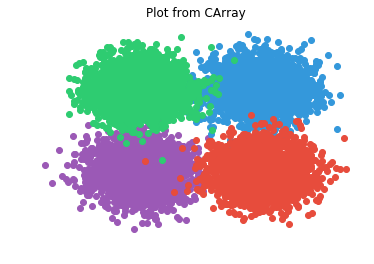

In [9]:
hdf5_path = "my_compressed_data.hdf5"
compressed_hdf5_file = tables.open_file(hdf5_path, mode='r')
# Here we slice [:] all the data back into memory, then operate on it
uncompressed_hdf5_data = compressed_hdf5_file.root.data[:]
uncompressed_hdf5_clusters = compressed_hdf5_file.root.clusters[:]
compressed_hdf5_file.close()

plot_clusters(uncompressed_hdf5_data, uncompressed_hdf5_clusters, "CArray")

## Next stop, EArray
So far so good (so what).  I can already anticipate questions such as "My data won't fit into memory at all...how can I get it into a PyTables array"?

Fear not, the EArray method is here to save the day! This is the workhorse Array type, and the one I use for 99% of my PyTables usage.  It is compressible _and_ extendable using the `append` method.  Barring a few exceptions, the EArray can take care of most data storage needs - lets see how it works.

In [20]:
hdf5_path = "my_extendable_compressed_data.hdf5"
hdf5_file = tables.open_file(hdf5_path, mode='w')
filters = tables.Filters(complevel=5, complib='blosc')
data_storage = hdf5_file.create_earray(hdf5_file.root, 'data',
                                      tables.Atom.from_dtype(sample_data.dtype),
                                      shape=(0, sample_data.shape[-1]),
                                      filters=filters,
                                      expectedrows=len(sample_data))
clusters_storage = hdf5_file.create_earray(hdf5_file.root, 'clusters',
                                          tables.Atom.from_dtype(sample_clusters.dtype),
                                          shape=(0,),
                                          filters=filters,
                                          expectedrows=len(sample_clusters))
for n, (d, c) in enumerate(zip(sample_data, sample_clusters)):
    data_storage.append(sample_data[n][None])
    clusters_storage.append(sample_clusters[n][None])
hdf5_file.close()

After adding data and (lossless-ly) compressing using EArray, we want to be sure that data retrieval is easy. Plotting the clusters should take care of this, and we do it just as we did for the CArray. In addition, we can also slice subsets of the EArray (e.g. hdf5_file.root.data[10:100]) which only brings that portion of the data into memory. For dealing with very large datasets this is extremely useful - only the sliced data is ever in memory, and python will get rid of the memory once the slice is not used anymore.

You can control memory usage by how much data is sliced out of an EArray, and python will clean up after you are done using that slice. The data stays on disk, so you can fetch it again if needed.

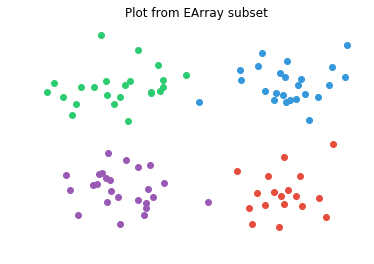

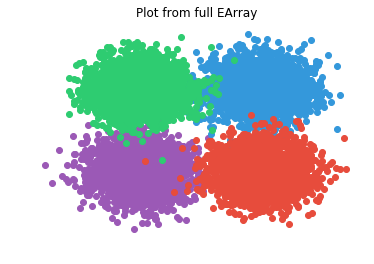

In [33]:
hdf5_path = "my_extendable_compressed_data.hdf5"
extendable_hdf5_file = tables.open_file(hdf5_path, mode='r')
extendable_hdf5_data = extendable_hdf5_file.root.data[:]
extendable_hdf5_clusters = extendable_hdf5_file.root.clusters[:]
plot_clusters(extendable_hdf5_file.root.data[10:100],
              extendable_hdf5_file.root.clusters[10:100], "EArray subset")
plot_clusters(extendable_hdf5_data, extendable_hdf5_clusters, "full EArray")
extendable_hdf5_file.close()

We can also open old hdf5 files created with PyTables, and add new data into an EArray. For example, if you were processing daily data from a point-of-sale application an hdf5 file could be used to store new information as it comes in. As a bonus, your sysadmin/DBA people will have a heart attack because you are not using databases/backups... but I digress. hdf5 files are really great for something that is basically a numpy array, but much too large to fit in memory.


In [34]:
hdf5_path = "my_extendable_compressed_data.hdf5"
extendable_hdf5_file = tables.open_file(hdf5_path, mode='a')
extendable_hdf5_data = extendable_hdf5_file.root.data
extendable_hdf5_clusters = extendable_hdf5_file.root.clusters
print("Length of current data: %i" % len(extendable_hdf5_data))
print("Length of current cluster labels: %i" % len(extendable_hdf5_clusters))
n_added = 5
print("Now adding %i elements to each" % n_added)
for n, (d, c) in enumerate(zip(sample_data[:n_added], sample_clusters[:n_added])):
    extendable_hdf5_data.append(sample_data[n][None])
    extendable_hdf5_clusters.append(sample_clusters[n][None])
extendable_hdf5_file.close()

extendable_hdf5_file = tables.open_file(hdf5_path, mode='r')
print("Length of current data: %i" % len(extendable_hdf5_file.root.data))
print("Length of current cluster labels: %i" % len(extendable_hdf5_file.root.clusters))
extendable_hdf5_file.close()

Length of current data: 10000
Length of current cluster labels: 10000
Now adding 5 elements to each
Length of current data: 10005
Length of current cluster labels: 10005
